# 08 - Explainability (SHAP & LIME)

Goal: provide transparent explanations for model decisions, aligning with ethical and regulatory expectations.

Tools:
- SHAP (TreeExplainer for tree-based models)
- LIME (local explanations for individual predictions)

We use the models trained in previous steps (proxy XGBoost for SHAP, NN for LIME).

c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data...

Training Proxy XGBoost for SHAP Analysis...
Calculating SHAP values...
Plotting SHAP Summary...


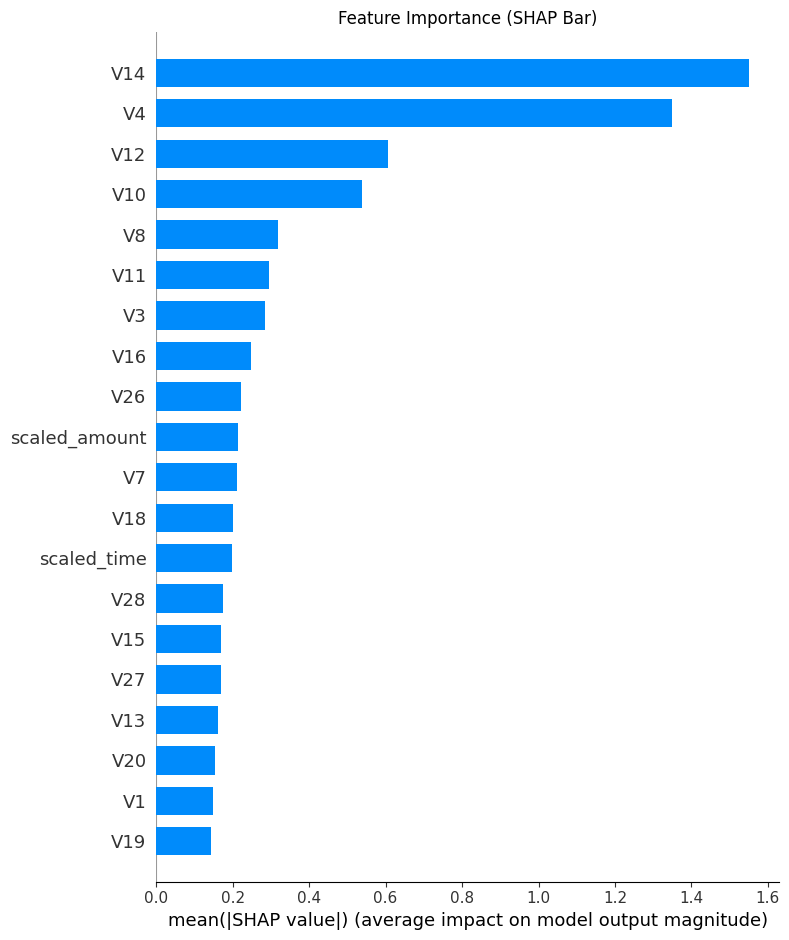

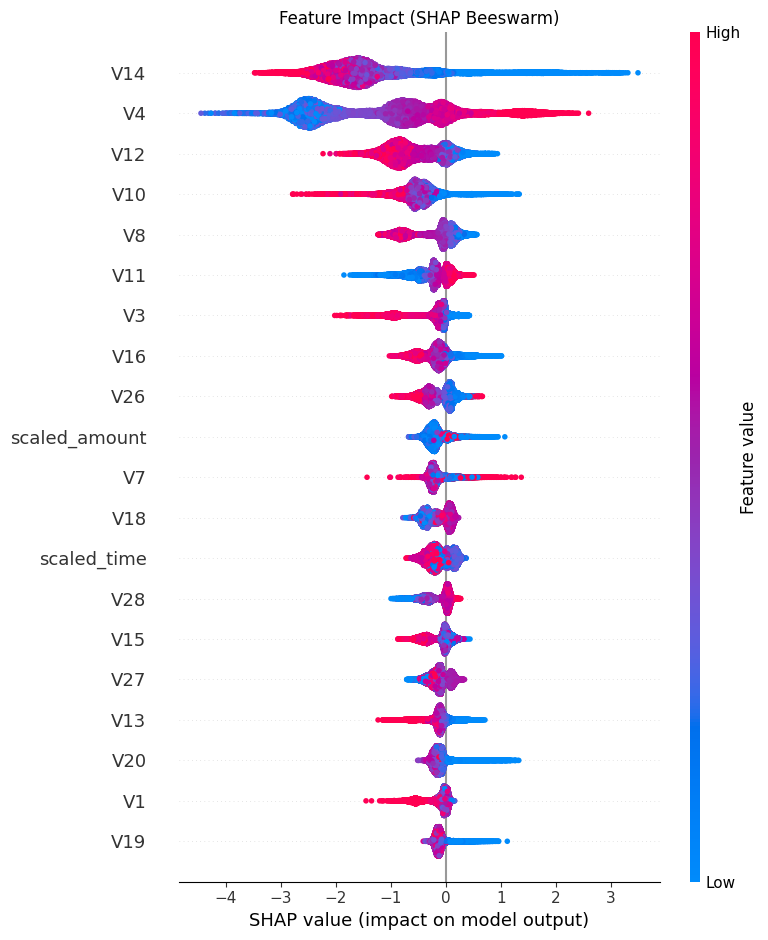


Loading Neural Network for LIME Analysis...

Explaining prediction for Test Sample Index: 840 (Actual Label: Fraud)


c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\venv\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version

Intercept 0.02517304919776181
Prediction_local [0.10397413]
Right: 0.33411968
LIME Explanation (Top Features for this sample):
V3 <= -0.89: 0.0155
V4 > 0.74: 0.0130
V14 <= -0.43: 0.0124
scaled_amount <= -0.23: 0.0100
V12 <= -0.40: 0.0098
V1 <= -0.92: 0.0084
V2 > 0.80: -0.0076
V5 <= -0.69: 0.0068
V10 <= -0.54: 0.0063
V11 > 0.74: 0.0043


c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\venv\Lib\site-packages\lime\lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version

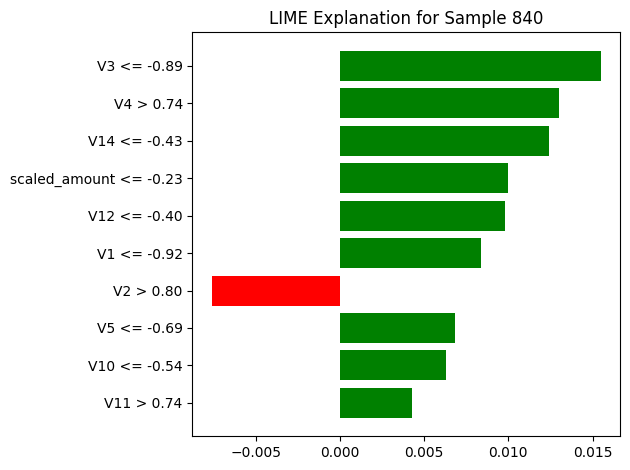

In [1]:
# 1. Setup and Data Loading
import shap
import lime
from lime import lime_tabular
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from pathlib import Path

pd.set_option('display.max_columns', None)
shap.initjs()

PROCESSED_DIR = Path('../data/processed/new_analysis')
MODELS_DIR = Path('../models')

print("Loading data...")
X_train = pd.read_csv(PROCESSED_DIR / 'X_train_scaled.csv')
y_train = pd.read_csv(PROCESSED_DIR / 'y_train.csv').squeeze()
X_test = pd.read_csv(PROCESSED_DIR / 'X_test_scaled.csv')
y_test = pd.read_csv(PROCESSED_DIR / 'y_test.csv').squeeze()

feature_names = X_train.columns.tolist()

# 2. SHAP with Tree Models
# Training a proxy XGBoost to demonstrate TreeExplainer
print("\nTraining Proxy XGBoost for SHAP Analysis...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# Calculate SHAP values
print("Calculating SHAP values...")
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

print("Plotting SHAP Summary...")
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Feature Importance (SHAP Bar)")
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Feature Impact (SHAP Beeswarm)")
plt.tight_layout()
plt.show()

# 3. LIME with Neural Network
print("\nLoading Neural Network for LIME Analysis...")

# Define the custom loss function again so Keras can load it
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal_loss = alpha_t * tf.math.pow((1 - p_t), gamma) * bce
        return tf.reduce_mean(focal_loss)
    return focal_loss_fixed

try:
    # We must pass the custom loss function object with the SAME name as expected by the saved model
    custom_loss_instance = binary_focal_loss(gamma=2.0, alpha=0.25)
    
    nn_model = keras.models.load_model(
        MODELS_DIR / 'best_nn_model_refactored.keras',
        custom_objects={'focal_loss_fixed': custom_loss_instance}
    )
    
    # LIME Explainer
    explainer_lime = lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=feature_names,
        class_names=['Non-Fraud', 'Fraud'],
        mode='classification',
        verbose=True
    )

    def nn_predict_proba(data):
        probs = nn_model.predict(data, verbose=0)
        return np.hstack((1-probs, probs))

    # Find a fraud case in test set
    fraud_indices = np.where(y_test == 1)[0]
    if len(fraud_indices) > 0:
        idx = fraud_indices[0] # First fraud sample
        print(f"\nExplaining prediction for Test Sample Index: {idx} (Actual Label: Fraud)")
        
        exp = explainer_lime.explain_instance(
            data_row=X_test.iloc[idx], 
            predict_fn=nn_predict_proba,
            num_features=10
        )
        
        print("LIME Explanation (Top Features for this sample):")
        for feat, weight in exp.as_list():
            print(f"{feat}: {weight:.4f}")
            
        exp.as_pyplot_figure()
        plt.title(f"LIME Explanation for Sample {idx}")
        plt.tight_layout()
        plt.show()
    else:
        print("No fraud samples found in test set to explain.")

except Exception as e:
    print(f"Could not load or explain Neural Network: {e}")

## Summary
- **SHAP** provides a global view of feature importance, highlighting which features (e.g., Transaction Amount, V-features) drive the model's decisions consistently.
- **LIME** validates individual predictions, crucial for investigating false positives or confirming true fraud cases in a regulatory context.